<a href="https://colab.research.google.com/github/machiwao/CCADMACL_EXERCISES_COM222ML/blob/main/Exercise6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 6

Netflix is the world's largest online streaming service provider, with over 220 million subscribers. It is crucial that they effectively cluster the shows that are hosted on their platform in order to enhance the user experience, thereby preventing subscribers from ending their subscription.

We will be able to understand the shows that are similar to and different from one another by creating clusters, which may be leveraged to offer the consumers personalized show suggestions depending on their preferences.

## Instructions

1. Your task is to group the Netflix shows into certain clusters such that the shows within a cluster are similar to each other and the shows in different clusters are dissimilar to each other. Use Principal Component Analysis and any Clustering Algorithm.

2. After creating the clusters, profile each cluster that you have created.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud, STOPWORDS
import re
import string
string.punctuation
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer

from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, AgglomerativeClustering
import scipy.cluster.hierarchy as shc

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
df = pd.read_csv("https://github.com/robitussin/CCADMACL_EXERCISES/blob/353cd84703a9e313ee7ecf37fb97a067aa81ddbc/netflix.csv?raw=true")

In [ ]:
df.head()

show_id     type  title           director  \
0      s1  TV Show     3%                NaN   
1      s2    Movie   7:19  Jorge Michel Grau   
2      s3    Movie  23:59       Gilbert Chan   
3      s4    Movie      9        Shane Acker   
4      s5    Movie     21     Robert Luketic   

                                                cast        country  \
0  João Miguel, Bianca Comparato, Michel Gomes, R...         Brazil   
1  Demián Bichir, Héctor Bonilla, Oscar Serrano, ...         Mexico   
2  Tedd Chan, Stella Chung, Henley Hii, Lawrence ...      Singapore   
3  Elijah Wood, John C. Reilly, Jennifer Connelly...  United States   
4  Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...  United States   

          date_added  release_year rating   duration  \
0    August 14, 2020          2020  TV-MA  4 Seasons   
1  December 23, 2016          2016  TV-MA     93 min   
2  December 20, 2018          2011      R     78 min   
3  November 16, 2017          2009  PG-13     80 min   
4    January 1, 2020          2008  PG-13    123 min   

                                           listed_in  \
0  International TV Shows, TV Dramas, TV Sci-Fi &...   
1                       Dramas, International Movies   
2                Horror Movies, International Movies   
3  Action & Adventure, Independent Movies, Sci-Fi...   
4                                             Dramas   

                                         description  
0  In a future where the elite inhabit an island ...  
1  After a devastating earthquake hits Mexico Cit...  
2  When an army recruit is found dead, his fellow...  
3  In a postapocalyptic world, rag-doll robots hi...  
4  A brilliant group of students become card-coun...

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       7787 non-null   object
 1   type          7787 non-null   object
 2   title         7787 non-null   object
 3   director      5398 non-null   object
 4   cast          7069 non-null   object
 5   country       7280 non-null   object
 6   date_added    7777 non-null   object
 7   release_year  7787 non-null   int64 
 8   rating        7780 non-null   object
 9   duration      7787 non-null   object
 10  listed_in     7787 non-null   object
 11  description   7787 non-null   object
dtypes: int64(1), object(11)
memory usage: 730.2+ KB


In [ ]:
df.duplicated().sum()

0

In [ ]:
df.isna().sum()

show_id            0
type               0
title              0
director        2389
cast             718
country          507
date_added        10
release_year       0
rating             7
duration           0
listed_in          0
description        0
dtype: int64

In [ ]:
df[['director','cast','country']] = df[['director','cast','country']].fillna(' ')
df.dropna(axis=0, inplace=True)

In [ ]:
df.duplicated().sum()

0

# Feature Engineering

In [ ]:
df['textual_data'] = df['description'] + df['listed_in'] + df['rating'] + df['cast'] + df['country'] + df['director']

In [ ]:
stop_words = stopwords.words('english')

In [ ]:
def preprocess_text(text):
  # Convert to lowercase
  text = text.lower()
  # remove_digits_urls_special_chars
  text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
  text = re.sub(r'[^a-zA-Z]', ' ', text) # Remove non-alphabetic characters
  text = re.sub(r'\b(\w+)\1+\b', r'\1', text)  # Reduce repeated words to root word
  text = re.sub(r'\@\w+|\#', '', text)
  text = re.sub(r'[^\w\s]', '', text)
  text = text.strip()
  text = re.sub(r'\s+', ' ', text).strip()
  text = re.sub(r'\s+$', '', text)


  text = ' '.join([word for word in text.split() if word not in stop_words])

  # Lemmatization
  lemmatizer = WordNetLemmatizer()
  text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

  return text

In [ ]:
df['textual_data'] = df['textual_data'].apply(preprocess_text)

In [ ]:
df.textual_data[0]

'future elite inhabit island paradise far crowded slum get one chance join saved squalor international tv show tv drama tv sci fi fantasytv majo miguel bianca comparato michel gomes rodolfo valente vaneza oliveira rafael lozano viviane porto mel fronckowiak sergio mamberti zez motta celso frateschibrazil'

In [ ]:
tfidf = TfidfVectorizer(stop_words='english', lowercase=False, max_features=10000)
tfidf.fit(df['textual_data'])

dictionary = tfidf.vocabulary_.items()

In [ ]:
print(len(dictionary))

10000


In [ ]:
vector = tfidf.transform(df['textual_data']).toarray()

print(vector)
print(f'shape of the vector : {vector.shape}')
print(f'datatype : {type(vector)}')

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
shape of the vector : (7770, 10000)
datatype : <class 'numpy.ndarray'>


1. Apply dimensionality reduction using Principal Component Analysis
- Use the necessary number of principal components

In [ ]:
# put your answer here
pca = PCA(random_state=42)
pca.fit(vector)

PCA(random_state=42)

2. Create a scree plot for each principal component

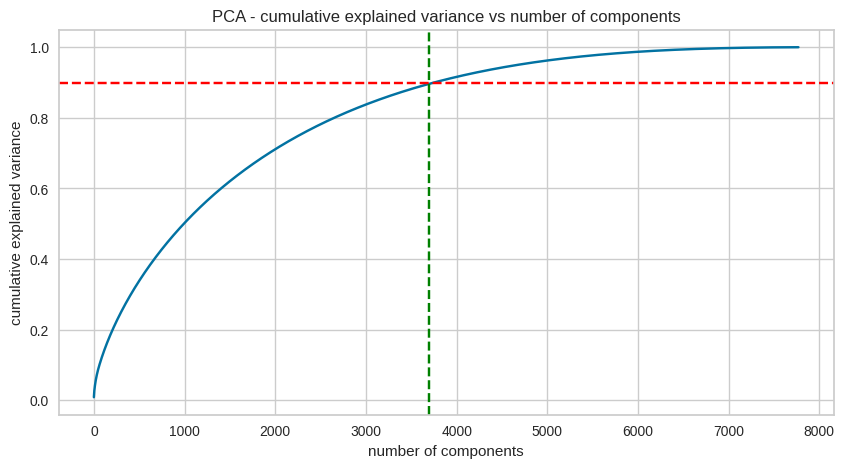

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('PCA - cumulative explained variance vs number of components')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axhline(y= 0.9, color='red', linestyle='--')
plt.axvline(x= 3700, color='green', linestyle='--')
plt.show()

In [ ]:
pca = PCA(n_components=3700, random_state=42)
pca.fit(vector)

PCA(n_components=3700, random_state=42)

In [ ]:
# transformed features
X = pca.transform(vector)

# shape of transformed vectors
X.shape

(7770, 3700)

3. Use any clustering algorithm to create clusters

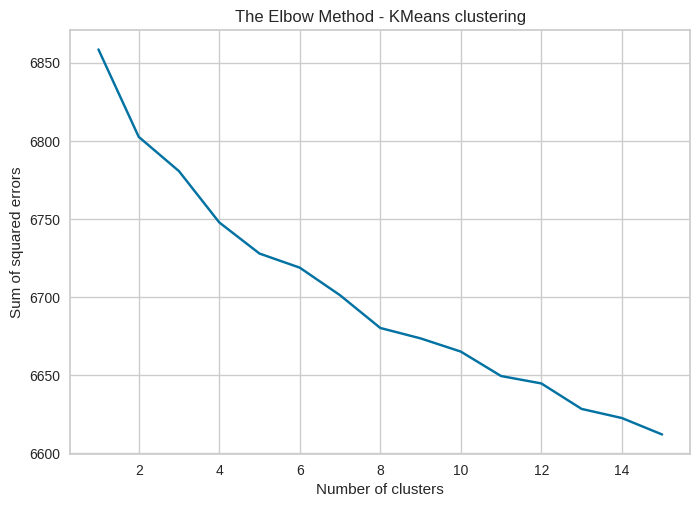

In [ ]:
# put your answer here
SSE = []

for k in range(1, 16):
  # Initialize the k-means model with the current value of k
  kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
  # Fit the model to the data
  kmeans.fit(X)
  # Compute the sum of squared errors for the model
  SSE.append(kmeans.inertia_)

# Plot the values of SSE
plt.plot(range(1, 16), SSE)
plt.title('The Elbow Method - KMeans clustering')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared errors')
plt.show()

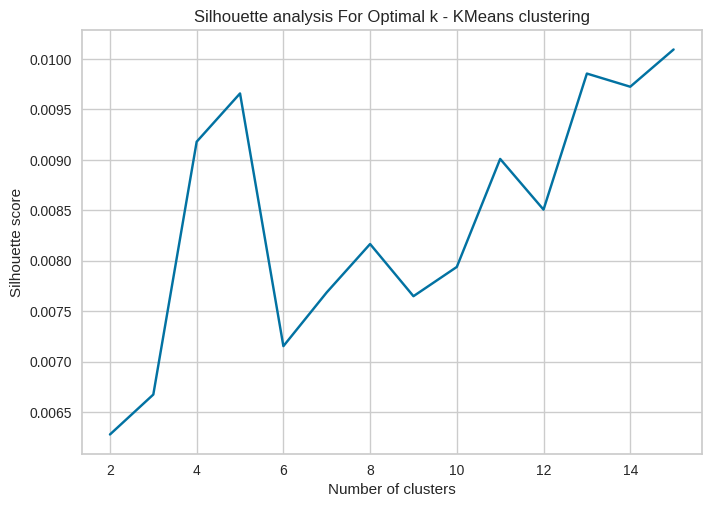

In [ ]:
silhouette_avg = []

for k in range(2, 16):
  # Initialize the k-means model with the current value of k
  kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
  # Fit the model to the data
  kmeans.fit(X)
  # Predict the cluster labels for each point in the data
  labels = kmeans.labels_
  # Compute the silhouette score for the model
  score = silhouette_score(X, labels)
  silhouette_avg.append(score)

# Plot the Silhouette analysis
plt.plot(range(2,16), silhouette_avg)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette analysis For Optimal k - KMeans clustering')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=42)
kmeans.fit(X)

KMeans(n_clusters=5, random_state=42)

In [ ]:
df['kmeans_cluster'] = kmeans.labels_

4. Profile each cluster that you have generated based on your experiments

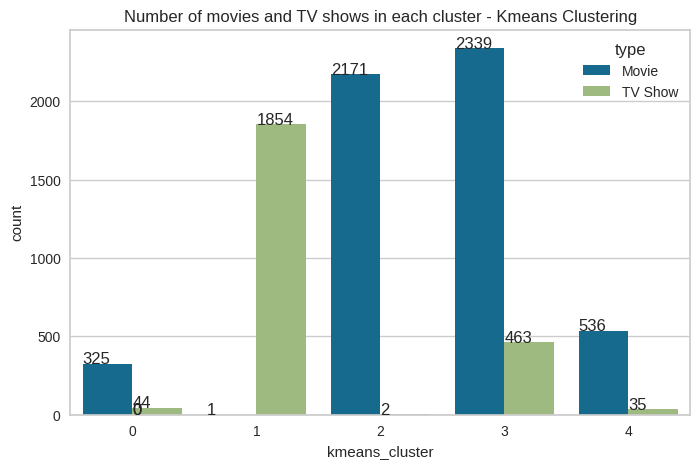

In [ ]:
# put your answer here
plt.figure(figsize=(8,5))
graph = sns.countplot(x='kmeans_cluster',data=df, hue='type')
plt.title('Number of movies and TV shows in each cluster - Kmeans Clustering')

for p in graph.patches:
   graph.annotate(format(p.get_height(), '.0f'), (p.get_x(), p.get_height()))

In [ ]:
def kmeans_worldcloud(cluster_number, column_name):

  df_wordcloud = df[['kmeans_cluster',column_name]].dropna()
  df_wordcloud = df_wordcloud[df_wordcloud['kmeans_cluster']==cluster_number]

  # text documents
  text = " ".join(word for word in df_wordcloud[column_name])

  # create the word cloud
  wordcloud = WordCloud(stopwords=set(STOPWORDS), background_color="white").generate(text)

  # Generate a word cloud image
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()

Cluster 0


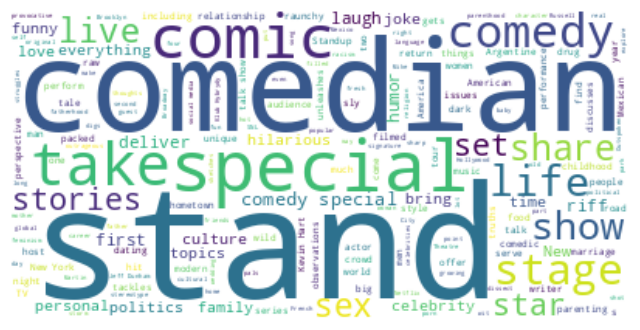

Cluster 1


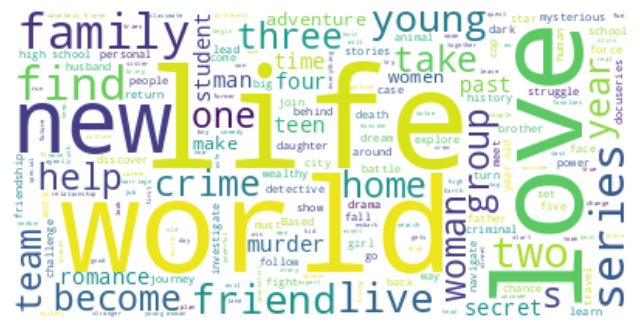

Cluster 2


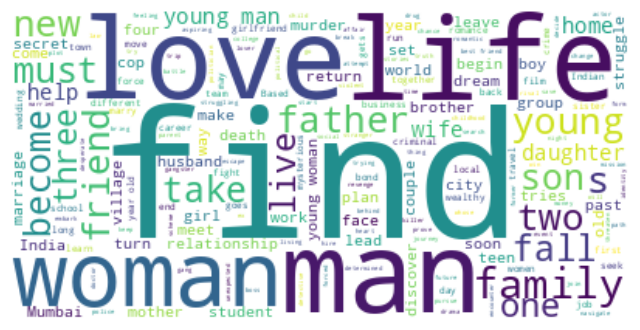

Cluster 3


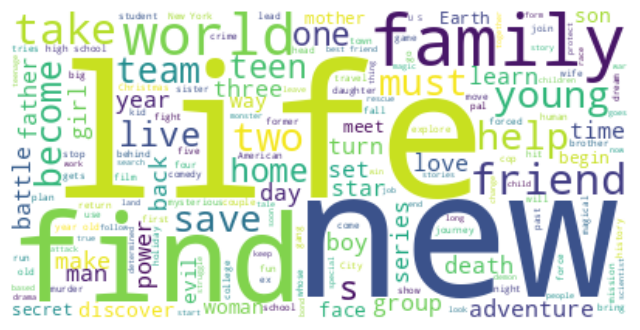

Cluster 4


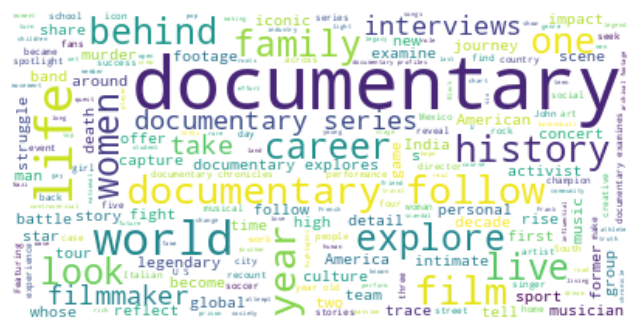

In [ ]:
for i in range(5):
  print(f'Cluster {i}')
  kmeans_worldcloud(i,'description')

Cluster 0


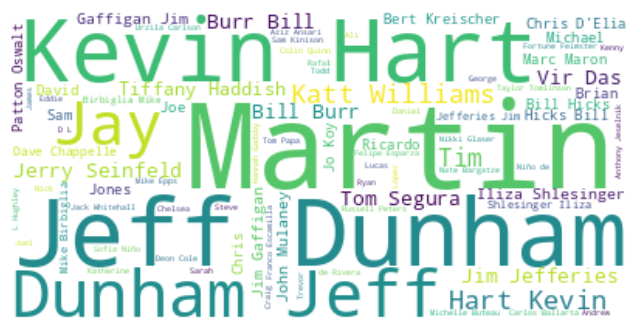

Cluster 1


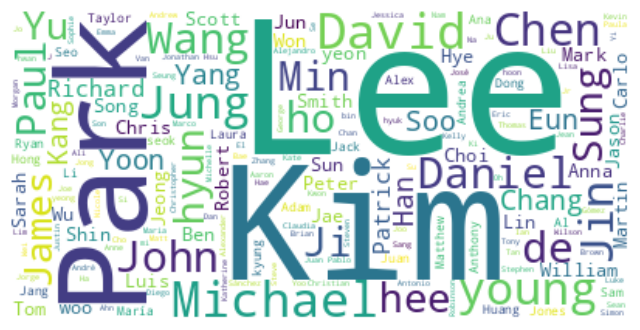

Cluster 2


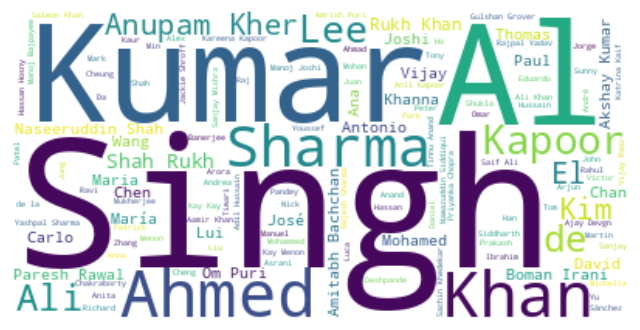

Cluster 3


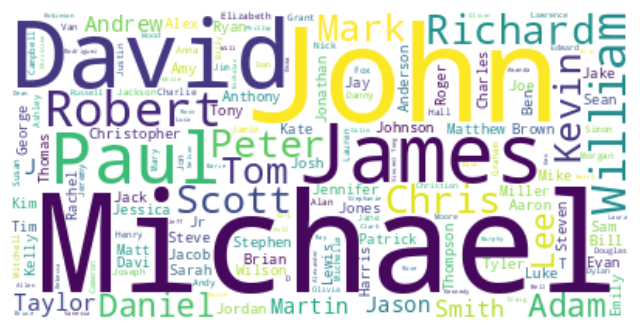

Cluster 4


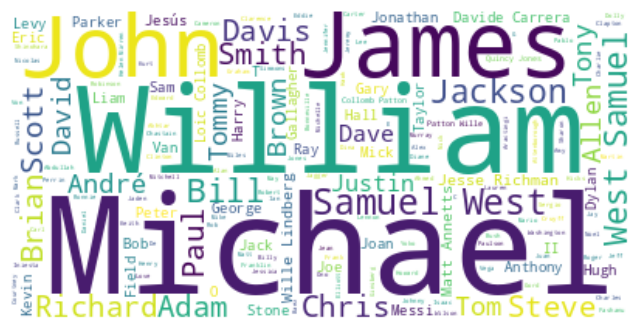

In [ ]:
for i in range(5):
  print(f'Cluster {i}')
  kmeans_worldcloud(i,'cast')

Cluster 0


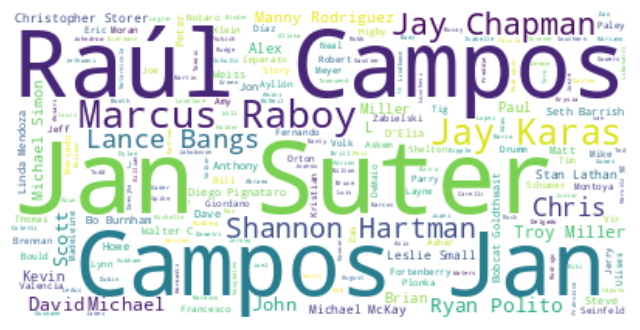

Cluster 1


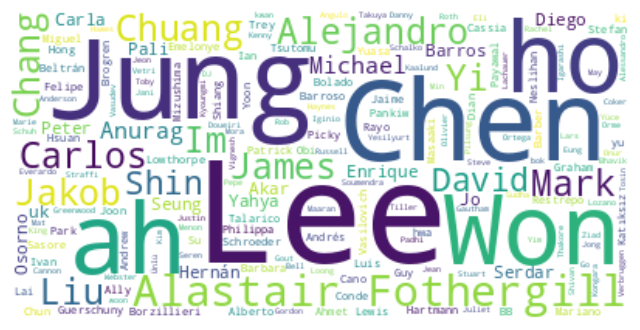

Cluster 2


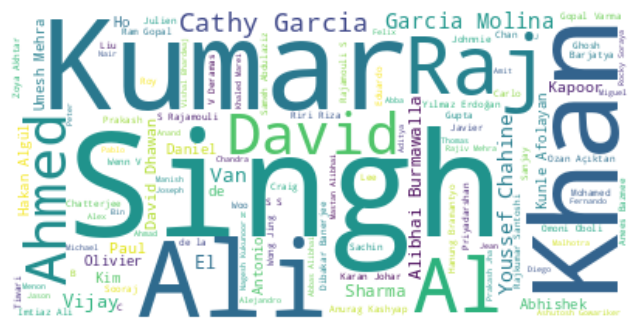

Cluster 3


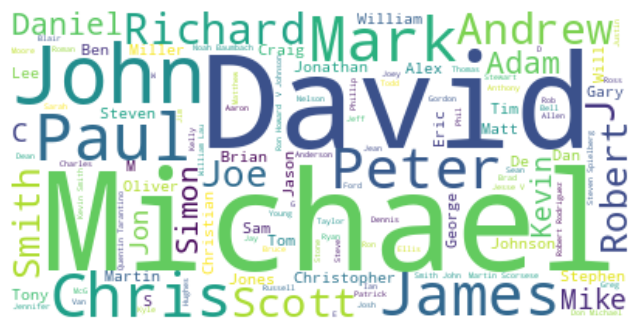

Cluster 4


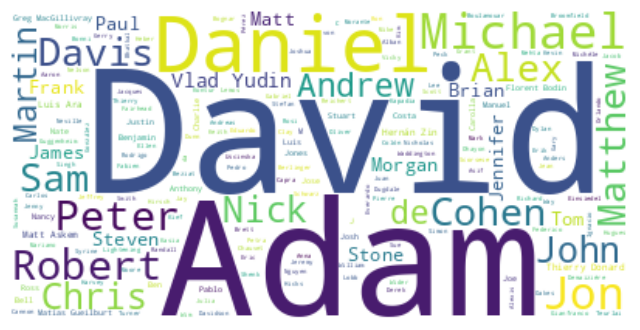

In [ ]:
for i in range(5):
  print(f'Cluster {i}')
  kmeans_worldcloud(i,'director')

Cluster 0


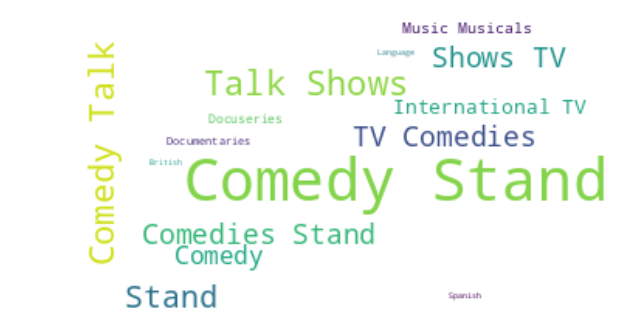

Cluster 1


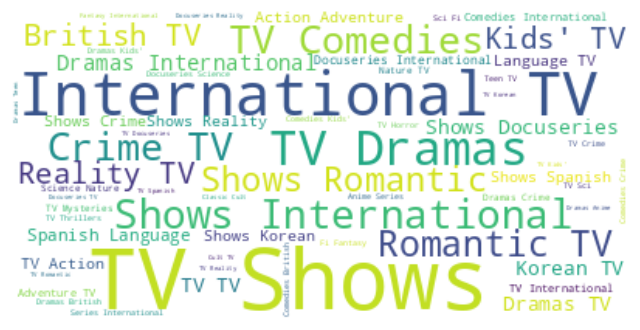

Cluster 2


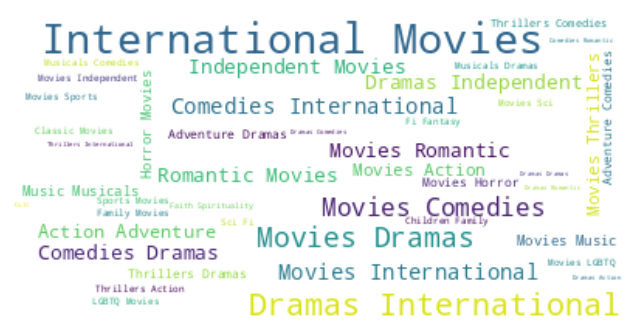

Cluster 3


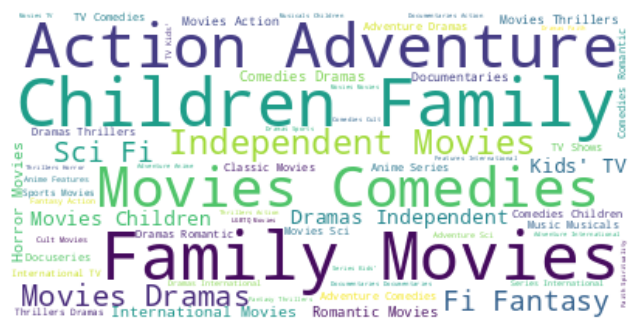

Cluster 4


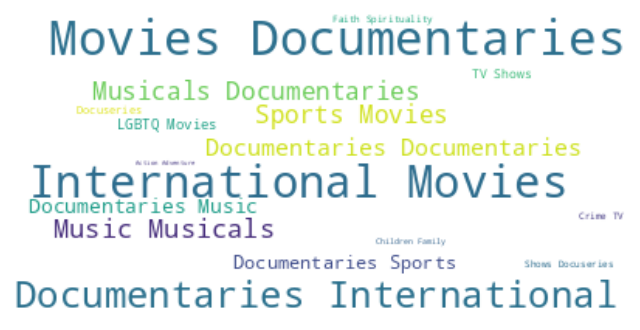

In [ ]:
for i in range(5):
  print(f'Cluster {i}')
  kmeans_worldcloud(i,'listed_in')

Cluster 0


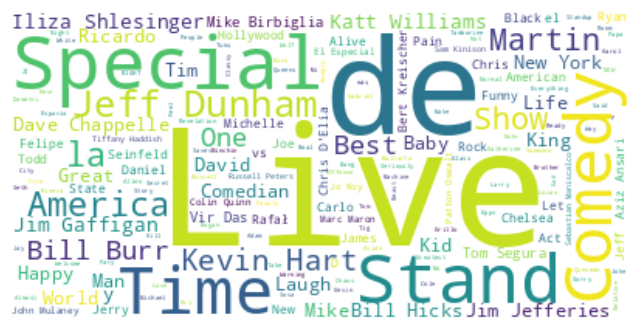

Cluster 1


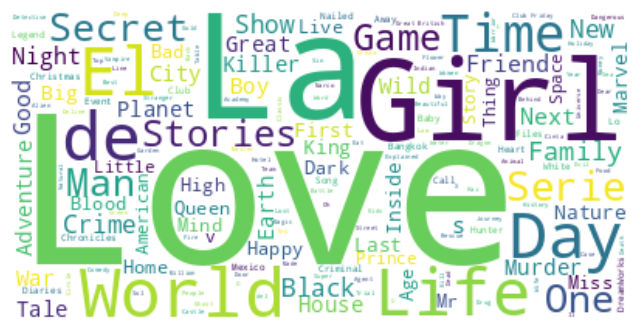

Cluster 2


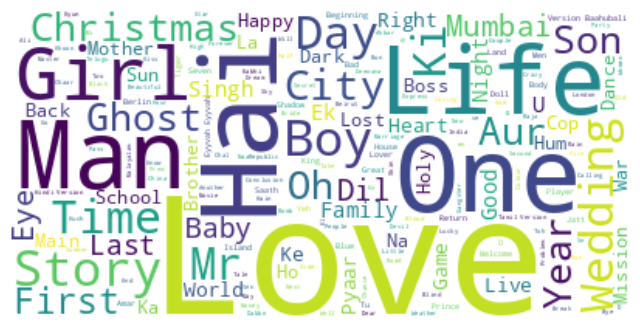

Cluster 3


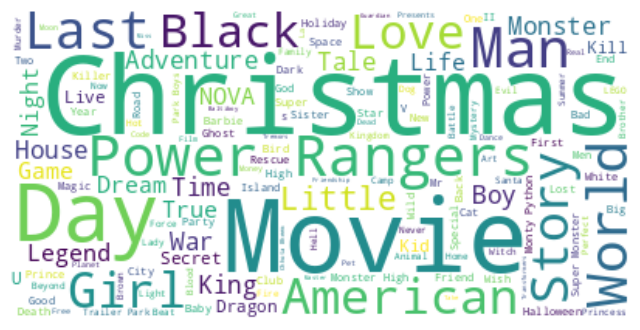

Cluster 4


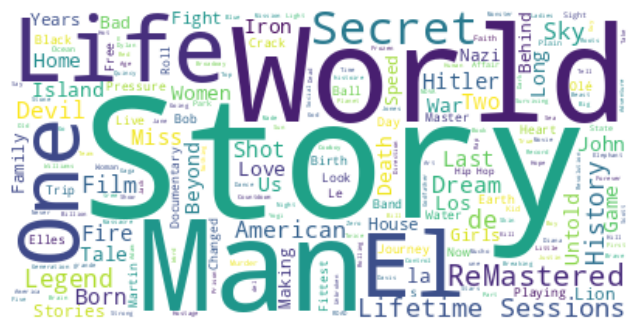

In [ ]:
for i in range(5):
  print(f'Cluster {i}')
  kmeans_worldcloud(i,'title')

In [ ]:
# Sample entries per cluster
df.groupby('kmeans_cluster').sample(10)

show_id     type                                              title  \
5507   s5508    Movie                  Seth Rogen's Hilarity for Charity   
5613   s5614    Movie                            Simon Amstell: Set Free   
7139   s7140    Movie                            Tom Segura: Disgraceful   
3209   s3210    Movie                          John Mulaney: New in Town   
7429   s7430    Movie         Vir Das: Outside In - The Lockdown Special   
1634   s1635    Movie                    David Batra: Elefanten i rummet   
5453   s5454    Movie                  Sebastian Maniscalco: Stay Hungry   
7718   s7719    Movie                     Yoo Byung Jae: Discomfort Zone   
1354   s1355    Movie                              Chris D'Elia: No Pain   
1753   s1754    Movie                        Dieter Nuhr: Nuhr in Berlin   
569     s570  TV Show                            ARASHI's Diary -Voyage-   
1792   s1793  TV Show                                      Doctor Foster   
6031   s6032  TV Show                     Terrace House: Tokyo 2019-2020   
4875   s4876  TV Show                                    Planet Earth II   
4179   s4180  TV Show                                            MONKART   
985     s986  TV Show                                      Blood & Water   
3531   s3532  TV Show           Larry Charles' Dangerous World of Comedy   
4086   s4087  TV Show                 Mighty Little Bheem: Kite Festival   
3907   s3908  TV Show                                             Maniac   
1462   s1463  TV Show                                         Collateral   
6394   s6395    Movie                         The Girl Allergic to Wi-Fi   
3306   s3307    Movie                                             Kardec   
7649   s7650    Movie                    Wives on Strike: The Revolution   
424     s425    Movie                                      Alles ist gut   
352     s353    Movie                                      Airplane Mode   
4669   s4670    Movie                                   Operation Mekong   
2953   s2954    Movie                                      Immoral Tales   
6926   s6927    Movie                                    The Third Party   
2011   s2012    Movie                                       Entanglement   
526     s527    Movie                      Ani... Dr. Kashinath Ghanekar   
366     s367    Movie                                          Al acecho   
4017   s4018    Movie       Meet the Trumps: From Immigrant to President   
4177   s4178    Movie                                        Money Talks   
1423   s1424    Movie                                     Closed Circuit   
3580   s3581  TV Show                   LEGO Elves: Secrets of Elvendale   
4763   s4764  TV Show                                        Paradise PD   
2654   s2655    Movie                         Haunting on Fraternity Row   
6731   s6732    Movie                         The Other Side of the Wind   
5544   s5545    Movie                                 Shattered Memories   
6026   s6027    Movie                               Terminator Salvation   
7361   s7362  TV Show                                 Unsolved Mysteries   
5332   s5333    Movie                                          Sacro GRA   
1794   s1795  TV Show                                   Documentary Now!   
3654   s3655    Movie               Listen Up! The Lives of Quincy Jones   
6133   s6134    Movie                                   The Birth Reborn   
2316   s2317    Movie                                 Functional Fitness   
5103   s5104    Movie  Ratones Paranoicos: The Band that Rocked Argen...   
5559   s5560    Movie                                    Shelby American   
1272   s1273    Movie   Chandani: The Daughter of the Elephant Whisperer   
6866   s6867    Movie  The Show Must Go On: The Queen + Adam Lambert ...   

                             director  \
5507                      Ryan Polito   
5613                    Julia Knowles   
7139 

**Profiling of Clusters**

Cluster 0:
*   Stand-Up Comedy Shows featuring Comedians

Cluster 1:
*   International TV Shows with a Variety of International Actors and Directors

Cluster 2:
*   International Movies with a Variety of International Actors and Directors

Cluster 3:
*   Variety Movies and TV Shows appealing to the General Mass

Cluster 4:
*   Documentaries or Docuseries portraying or influenced by real-life events






